# Do teams shoot better or worse in the NBA bubble?

First, let's get field goal % and three point % before the bubble. This will require the following steps:

1) Get the season schedule

2) Get the box score for every single game

3) For each game, get FGM, FGA, 3PM, 3PA

We'll use a modified version from the `basketball_reference_scaper`'s `get_schedule` function.

Normally, the `months` variable doesn't include July or August, but let's modify it so it does.

In [15]:
import pandas as pd
from datetime import datetime
from requests import get
from bs4 import BeautifulSoup

def get_schedule(season, playoffs=False):
    months = ['October', 'November', 'December', 'January', 'February', 'March',
            'July', 'August']
    df = pd.DataFrame()
    for month in months:
        r = get(f'https://www.basketball-reference.com/leagues/NBA_{season}_games-{month.lower()}.html')
        if r.status_code==200:
            soup = BeautifulSoup(r.content, 'html.parser')
            table = soup.find('table', attrs={'id': 'schedule'})
            month_df = pd.read_html(str(table))[0]
            df = df.append(month_df)
    df = df.reset_index()
    cols_to_remove = [i for i in df.columns if 'Unnamed' in i]
    cols_to_remove += [i for i in df.columns if 'Notes' in i]
    cols_to_remove += [i for i in df.columns if 'Start' in i]
    cols_to_remove += [i for i in df.columns if 'Attend' in i]
    cols_to_remove += ['index']
    df = df.drop(cols_to_remove, axis=1)
    df.columns = ['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS']
    playoff_loc = df[df['DATE']=='Playoffs']
    if len(playoff_loc.index)>0:
        playoff_index = playoff_loc.index[0]
    else:
        playoff_index = len(df)
    if playoffs:
        df = df[playoff_index+1:]
    else:
        df = df[:playoff_index]
    df['DATE'] = df['DATE'].apply(lambda x: pd.to_datetime(x))
    return df

def get_standings(date=None):
    if date is None:
        date = datetime.now()
    else:
        date = pd.to_datetime(date)
    d = {}
    r = get(f'https://www.basketball-reference.com/friv/standings.fcgi?month={date.month}&day={date.day}&year={date.year}')
    if r.status_code==200:
        soup = BeautifulSoup(r.content, 'html.parser')
        e_table = soup.find('table', attrs={'id': 'standings_e'})
        e_df = pd.read_html(str(e_table))[0]
        w_table = soup.find('table', attrs={'id': 'standings_w'})
        w_df = pd.read_html(str(w_table))[0]
        e_df.rename(columns={'Eastern Conference': 'TEAM'}, inplace=True)
        w_df.rename(columns={'Western Conference': 'TEAM'}, inplace=True)
        d['EASTERN_CONF'] = e_df
        d['WESTERN_CONF'] = w_df
    return d

In [16]:
schedule = get_schedule(2020)
schedule

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS
0,2019-10-22,New Orleans Pelicans,122.0,Toronto Raptors,130.0
1,2019-10-22,Los Angeles Lakers,102.0,Los Angeles Clippers,112.0
2,2019-10-23,Chicago Bulls,125.0,Charlotte Hornets,126.0
3,2019-10-23,Detroit Pistons,119.0,Indiana Pacers,110.0
4,2019-10-23,Cleveland Cavaliers,85.0,Orlando Magic,94.0
...,...,...,...,...,...
1054,2020-08-13,Portland Trail Blazers,NaN,Brooklyn Nets,NaN
1055,2020-08-14,Philadelphia 76ers,NaN,Houston Rockets,NaN
1056,2020-08-14,Miami Heat,NaN,Indiana Pacers,NaN
1057,2020-08-14,Oklahoma City Thunder,NaN,Los Angeles Clippers,NaN


Now, we can acquire the stats for every team game prior to the break.

In [17]:
from basketball_reference_scraper.box_scores import get_box_scores
def get_game_stats(date, t1, t2):
    box_score = get_box_scores(date, t1, t2)
    if t1 not in before:
        before[t1] = {'FG': 0, 'FGA': 0, '3P': 0, '3PA': 0}
    if t2 not in before:
        before[t2] = {'FG': 0, 'FGA': 0, '3P': 0, '3PA': 0}
    before[t1]['FG']+=int(box_score[t1]['FG'].values[-1])
    before[t1]['FGA']+=int(box_score[t1]['FGA'].values[-1])
    before[t1]['3P']+=int(box_score[t1]['3P'].values[-1])
    before[t1]['3PA']+=int(box_score[t1]['3PA'].values[-1])
    before[t2]['FG']+=int(box_score[t2]['FG'].values[-1])
    before[t2]['FGA']+=int(box_score[t2]['FGA'].values[-1])
    before[t2]['3P']+=int(box_score[t2]['3P'].values[-1])
    before[t2]['3PA']+=int(box_score[t2]['3PA'].values[-1])

In [18]:
from basketball_reference_scraper.constants import TEAM_TO_TEAM_ABBR
before_written = True
before = {}
for i, r in schedule.iterrows():
    if r['DATE'].month==7 or r['DATE'].month==8 or before_written:
        break
    print(r['DATE'])
    t1 = TEAM_TO_TEAM_ABBR[r['HOME'].upper()]
    t2 = TEAM_TO_TEAM_ABBR[r['VISITOR'].upper()]
    date = r['DATE'].strftime('%Y-%m-%d')
    get_game_stats(date, t1, t2)
    
if before_written:
    before = pd.read_csv('before.csv')

In [19]:
before = before.set_index('Unnamed: 0')

In [20]:
if not before_written:
    for t in before:
        before[t]['FG%'] = before[t]['FG']/float(before[t]['FGA'])
        before[t]['3P%'] = before[t]['3P']/float(before[t]['3PA'])

Now we can acquire all the games during the bubble era:

In [21]:
def get_game_stats_2(date, t1, t2):
    box_score = get_box_scores(date, t1, t2)
    if t1 not in after:
        after[t1] = {'FG': 0, 'FGA': 0, '3P': 0, '3PA': 0}
    if t2 not in after:
        after[t2] = {'FG': 0, 'FGA': 0, '3P': 0, '3PA': 0}
    after[t1]['FG']+=int(box_score[t1]['FG'].values[-1])
    after[t1]['FGA']+=int(box_score[t1]['FGA'].values[-1])
    after[t1]['3P']+=int(box_score[t1]['3P'].values[-1])
    after[t1]['3PA']+=int(box_score[t1]['3PA'].values[-1])
    after[t2]['FG']+=int(box_score[t2]['FG'].values[-1])
    after[t2]['FGA']+=int(box_score[t2]['FGA'].values[-1])
    after[t2]['3P']+=int(box_score[t2]['3P'].values[-1])
    after[t2]['3PA']+=int(box_score[t2]['3PA'].values[-1])

In [22]:
after = {}
now = pd.Timestamp.now().strftime('%Y-%m-%d')
for i, r in schedule.iterrows():
    if r['DATE'].month==7 or r['DATE'].month==8:
        print(r['DATE'])
        t1 = TEAM_TO_TEAM_ABBR[r['HOME'].upper()]
        t2 = TEAM_TO_TEAM_ABBR[r['VISITOR'].upper()]
        date = r['DATE'].strftime('%Y-%m-%d')
        if date==now:
            break
        get_game_stats_2(date, t1, t2)

2020-07-30 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-07-31 00:00:00
2020-07-31 00:00:00
2020-07-31 00:00:00
2020-07-31 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-01 00:00:00
2020-08-01 00:00:00
2020-08-01 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-02 00:00:00
2020-08-02 00:00:00
2020-08-02 00:00:00
2020-08-02 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-03 00:00:00
2020-08-03 00:00:00
2020-08-03 00:00:00
2020-08-03 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-04 00:00:00
2020-08-04 00:00:00
2020-08-04 00:00:00
2020-08-04 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-05 00:00:00
2020-08-05 00:00:00
2020-08-05 00:00:00
2020-08-05 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-06 00:00:00
2020-08-06 00:00:00
2020-08-06 00:00:00
2020-08-06 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00


In [23]:
after

{'NOP': {'FG': 162, 'FGA': 343, '3P': 45, '3PA': 124},
 'UTA': {'FG': 146, 'FGA': 338, '3P': 46, '3PA': 153},
 'LAL': {'FG': 168, 'FGA': 412, '3P': 37, '3PA': 158},
 'LAC': {'FG': 161, 'FGA': 338, '3P': 63, '3PA': 143},
 'BRK': {'FG': 170, 'FGA': 379, '3P': 53, '3PA': 164},
 'ORL': {'FG': 163, 'FGA': 338, '3P': 52, '3PA': 144},
 'POR': {'FG': 176, 'FGA': 368, '3P': 67, '3PA': 142},
 'MEM': {'FG': 164, 'FGA': 368, '3P': 43, '3PA': 143},
 'WAS': {'FG': 159, 'FGA': 358, '3P': 35, '3PA': 104},
 'PHO': {'FG': 172, 'FGA': 361, '3P': 49, '3PA': 131},
 'MIL': {'FG': 167, 'FGA': 342, '3P': 54, '3PA': 164},
 'BOS': {'FG': 166, 'FGA': 341, '3P': 59, '3PA': 139},
 'SAS': {'FG': 176, 'FGA': 362, '3P': 46, '3PA': 110},
 'SAC': {'FG': 184, 'FGA': 383, '3P': 52, '3PA': 142},
 'DAL': {'FG': 160, 'FGA': 375, '3P': 53, '3PA': 169},
 'HOU': {'FG': 158, 'FGA': 363, '3P': 80, '3PA': 219},
 'DEN': {'FG': 175, 'FGA': 351, '3P': 43, '3PA': 124},
 'MIA': {'FG': 146, 'FGA': 319, '3P': 63, '3PA': 163},
 'OKC': {'

In [24]:
for t in after:
    after[t]['FG%'] = after[t]['FG']/float(after[t]['FGA'])
    after[t]['3P%'] = after[t]['3P']/float(after[t]['3PA'])
after = pd.DataFrame(after).transpose()
after

,FG,FGA,3P,3PA,FG%,3P%
NOP,162.0,343.0,45.0,124.0,0.472303,0.362903
UTA,146.0,338.0,46.0,153.0,0.431953,0.300654
LAL,168.0,412.0,37.0,158.0,0.407767,0.234177
LAC,161.0,338.0,63.0,143.0,0.476331,0.440559
BRK,170.0,379.0,53.0,164.0,0.448549,0.323171
ORL,163.0,338.0,52.0,144.0,0.482249,0.361111
POR,176.0,368.0,67.0,142.0,0.478261,0.471831
MEM,164.0,368.0,43.0,143.0,0.445652,0.300699
WAS,159.0,358.0,35.0,104.0,0.444134,0.336538
PHO,172.0,361.0,49.0,131.0,0.476454,0.374046


Let's define a new dataframe `diff` that contains the difference in FG% and 3P% for all teams in the bubble.

In [28]:
diff = pd.DataFrame()
diff['FG% after - FG% before'] = (after['FG%']-before['FG%'])*100
diff['3P% after - 3P% before'] = (after['3P%']-before['3P%'])*100
diff.dropna(inplace=True)
diff

,FG% after - FG% before,3P% after - 3P% before
BOS,2.751843,6.190335
BRK,0.468277,-1.690356
DAL,-3.575245,-5.558809
DEN,2.799744,-1.083835
HOU,-1.829680,1.713296
IND,1.455354,-0.196318
LAC,1.213899,7.409689
LAL,-7.690768,-12.069406
MEM,-2.432922,-5.095994
MIA,-1.187863,0.328011


Now, let's plot the results of FG% after - FG% before and 3P% after - 3P% before in descending order:

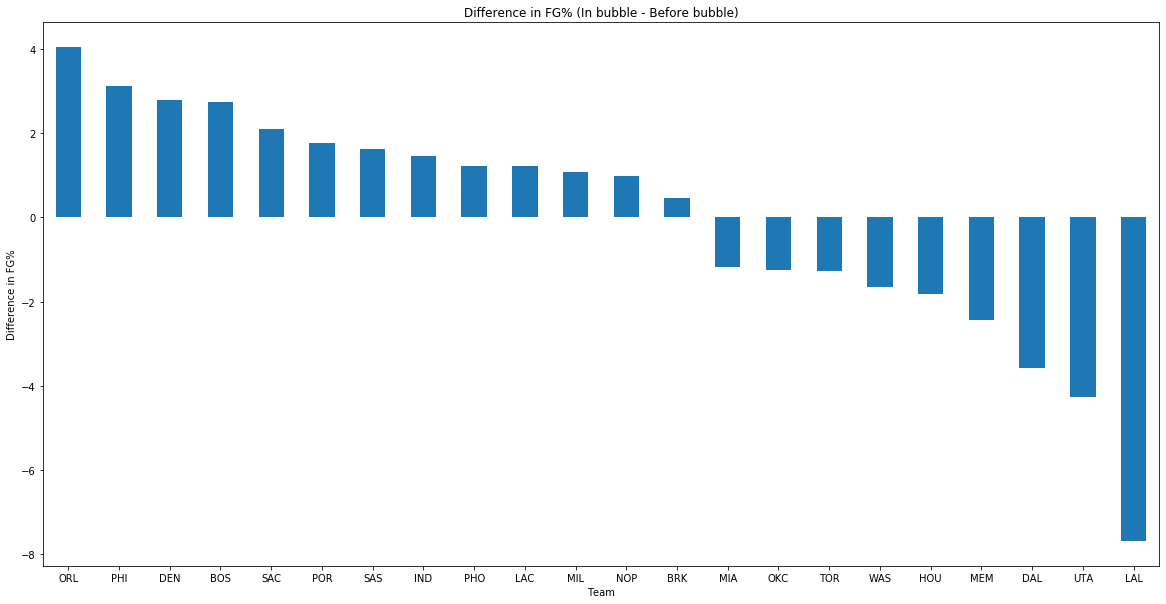

In [31]:
ax = diff.sort_values('FG% after - FG% before', ascending=False).plot.bar(y='FG% after - FG% before', rot=0, figsize=(20, 10))
ax.set_title('Difference in FG% (In bubble - Before bubble)')
ax.set_xlabel('Team')
ax.set_ylabel('Difference in FG%')
ax.get_legend().remove()

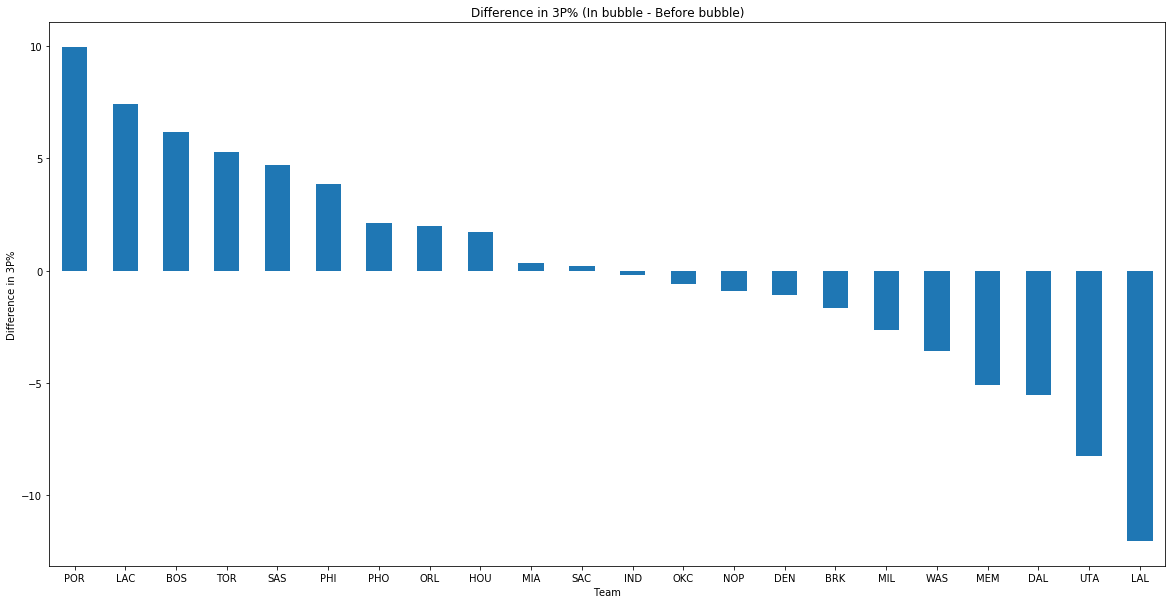

In [30]:
ax = diff.sort_values('3P% after - 3P% before', ascending=False).plot.bar(y='3P% after - 3P% before', rot=0, figsize=(20, 10))
ax.set_title('Difference in 3P% (In bubble - Before bubble)')
ax.set_xlabel('Team')
ax.set_ylabel('Difference in 3P%')
ax.get_legend().remove()